<a href="https://colab.research.google.com/github/bofeng2268/qm2/blob/main/analysis_plot_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
!pip install seaborn
!pip install matplotlib
!pip install esda
!pip install Pillow
!pip install geopandas libpysal mgwr

In [153]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np

In [154]:
#from example
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from statsmodels.formula.api import ols
from esda.moran import Moran
from libpysal.weights import Queen
import geopandas as gpd
import requests
import json
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col
import libpysal as ps
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# Merging and Cleaning Data

In [155]:
#FILE PATHS
csv_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv'
topojson_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/topo_lad.json'
local_authorities_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/download6923730533685635445.csv'


In [156]:
#prepare the dataset for total disabled people density by regions
#link source:
total=pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv')
eng_disability_data = total[total['Lower tier local authorities Code'].str.startswith('E')]
filtered_disability_data = eng_disability_data[eng_disability_data['Disability (5 categories) Code'].isin([1, 2])]
disabled = filtered_disability_data.groupby('Lower tier local authorities')['Observation'].sum().reset_index()
disabled['Lower tier local authorities'] = disabled['Lower tier local authorities'].apply(lambda string: string.strip()) #all values e togli spazi davanti e dietro



Renaming Lower Tier Local Authorities

Bristol --> Bristol, City of

Herefordshire --> Herefordshire, County of

Kingston upon Hull --> Kingston upon Hull, City of

North Northamptonshire --> East Northamptonshire

West Northamptonshire --> South Northamptonshire

In [157]:

rename_map = {
    'Bristol': 'Bristol, City of',
    'Herefordshire': 'Herefordshire, County of',
    'Kingston upon Hull': 'Kingston upon Hull, City of',
    'North Northamptonshire': 'East Northamptonshire',
    'West Northamptonshire': 'South Northamptonshire'
}

disabled['Lower tier local authorities'] = disabled['Lower tier local authorities'].map(rename_map).fillna(disabled['Lower tier local authorities'])

In [158]:
#prepare the blue badged population by regions
blue_badge = pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/Blue_badges_held.csv', delimiter=';')
blue_badges_narrowed =  blue_badge[['Local Authority', 'Total valid Blue Badges held by organisations and individuals']].copy()
filtered_blue_badges = blue_badges_narrowed[~blue_badges_narrowed['Local Authority'].str.contains('All')].copy()
filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].apply(lambda string: string.strip()) #all values e togli spazi davanti e dietro


filtered_blue_badges.reset_index(drop=True, inplace=True)



In [159]:
#TIMES 1000

filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'], errors='coerce')



# Now, multiply by 1000 and convert to integer
filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'].apply(lambda x : int(1000*x))


In [160]:
#RENAME

In [161]:
rename_map = {
    'North Northamptonshire': 'East Northamptonshire',
    'West Northamptonshire': 'South Northamptonshire',
    'Cambridgeshire': 'East Cambridgeshire',
    'Hampshire': 'East Hampshire',
    'Derbyshire': 'Derbyshire Dales',
    'Lancashire': 'West Lancashire',
    'Lincolnshire': 'Lincoln',
    'Somerset': 'South Somerset',
    'Surrey': 'Surrey Heath',
    'Warwickshire': 'North Warwickshire',
    'Leicestershire': 'North West Leicestershire'}

filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].map(rename_map).fillna(filtered_blue_badges['Local Authority'])
filtered_blue_badges

pd.set_option('display.max_rows', None)


In [162]:
# Function to do the division and create new local authorities
# take away the spaces in front and after the string in 'local authority
filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].apply(lambda string: string.strip()) #all values and delete spaces
def divide_and_create_local_authorities(df, original_la, new_local_authorities, division_factor):
    if original_la in df['Local Authority'].values:
        original_value = df[df['Local Authority'] == original_la]['Total valid Blue Badges held by organisations and individuals'].iloc[0]
        divided_value = original_value / division_factor

        # Creating new rows for the new local authorities
        for la in new_local_authorities:
            new_row = {'Local Authority': la, 'Total valid Blue Badges held by organisations and individuals': divided_value}
            df = df.append(new_row, ignore_index=True)

        # Remove the original local authority row
        df = df[df['Local Authority'] != original_la]

    return df


# Step 1 - Essex
new_local_authorities_essex = ['Braintree', 'Castle Point', 'Chelmsford', 'Colchester', 'Harlow', 'Maldon', 'Rochford', 'Uttlesford']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Essex', new_local_authorities_essex, 8)


filtered_blue_badges


# Step 2 (Worcestershire
new_local_authorities_worcestershire = ['Bromsgrove', 'Malvern Hills', 'Redditch', 'Worcester', 'Wychavon', 'Wyre Forest']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Worcestershire', new_local_authorities_worcestershire, 6)

filtered_blue_badges

# Hertfordshire aggiungere spazio (AGGIUNGERE NELLA ANALISI CHE BISOGNAVA METTERE LO SPAZIO)
new_local_authorities_hertfordshire = ['North Hertfordshire', 'South Hertfordshire']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Hertfordshire', new_local_authorities_hertfordshire, 2)

# Norfolk
new_local_authorities_norfolk = ["King's Lynn and West Norfolk", 'South Norfolk', 'North Norfolk']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Norfolk', new_local_authorities_norfolk, 3)

# Oxfordshire
new_local_authorities_oxfordshire = ['South Oxfordshire', 'West Oxfordshire']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Oxfordshire', new_local_authorities_oxfordshire, 2)

# Devon
new_local_authorities_devon = ['East Devon', 'Mid Devon', 'West Devon', 'North Devon']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Devon', new_local_authorities_devon, 4)



#By doing this we manage to have all datapoints from Blue Badges dataset to be merged with the mirrorred datapoints from the other datasets. Since Blue Badges is the one with less datapoints

<ipython-input-162-8def87483515>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-162-8def87483515>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-162-8def87483515>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-162-8def87483515>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-162-8def87483515>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-162-8def87483515>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

In [163]:
#merge the two datasets
merged_data = pd.merge(filtered_blue_badges, disabled, left_on='Local Authority', right_on='Lower tier local authorities', how='inner')


# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric(merged_data['Observation'])


In [164]:
#Transport Reliant People
# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric( merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric( merged_data['Observation'])

# Create the new column by subtracting the two columns
merged_data['Transport reliant people with a disability estimate'] =  merged_data['Observation'] -  merged_data['Total valid Blue Badges held by organisations and individuals']
merged_data



,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation,Transport reliant people with a disability estimate
0,County Durham,27884.000000,County Durham,119790,91906.000000
1,Darlington,5945.000000,Darlington,21104,15159.000000
2,Hartlepool,5530.000000,Hartlepool,21145,15615.000000
3,Middlesbrough,6546.000000,Middlesbrough,29520,22974.000000
4,Northumberland,16242.000000,Northumberland,67190,50948.000000
5,Redcar and Cleveland,7680.000000,Redcar and Cleveland,30483,22803.000000
6,Stockton-on-Tees,12810.000000,Stockton-on-Tees,39052,26242.000000
7,Gateshead,8951.000000,Gateshead,42548,33597.000000
8,Newcastle upon Tyne,9221.000000,Newcastle upon Tyne,56961,47740.000000
9,North Tyneside,8324.000000,North Tyneside,41748,33424.000000


In [165]:
#GET RID OF CITY OF LONDON - INACCURATE DATA POINT (provide Justification in analysis)
merged_data = merged_data[merged_data['Local Authority'] != 'City of London']
merged_data = merged_data.drop(['Lower tier local authorities'],axis=1)
merged_data.rename(columns={'Observation': 'Disable_population'}, inplace=True)
merged_data.rename(columns={'Total valid Blue Badges held by organisations and individuals': 'Blue_Badges_population'}, inplace=True)
merged_data.rename(columns={'Transport reliant people with a disability estimate': 'Transport_reliant_population'}, inplace=True)


#Summary Statistics

In [166]:
summary=merged_data.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
Blue_Badges_population,160.0,13067.33,9857.08,1768.0,7439.50,10346.75,14580.00,62975.0
Disable_population,160.0,42081.15,26105.32,294.0,24880.25,36891.00,53519.25,198064.0
Transport_reliant_population,160.0,29013.82,25062.61,-40706.0,18271.50,27365.50,40360.75,158004.0


In [167]:
# Setup the PrettyTable
table = PrettyTable()
table.field_names = ["Variable", "Mean", "St. Dev.", "Min", "25%", "50%", "75%", "Max"]
table.title = "Summary Statistics"

# Add data to the table
for row in summary.iterrows():
    table.add_row([row[0], row[1]["mean"], row[1]["std"], row[1]["min"], row[1]["25%"], row[1]["50%"], row[1]["75%"], row[1]["max"]])

# Print the table
print(table)

+-----------------------------------------------------------------------------------------------------------+
|                                             Summary Statistics                                            |
+------------------------------+----------+----------+----------+----------+----------+----------+----------+
|           Variable           |   Mean   | St. Dev. |   Min    |   25%    |   50%    |   75%    |   Max    |
+------------------------------+----------+----------+----------+----------+----------+----------+----------+
|    Blue_Badges_population    | 13067.33 | 9857.08  |  1768.0  |  7439.5  | 10346.75 | 14580.0  | 62975.0  |
|      Disable_population      | 42081.15 | 26105.32 |  294.0   | 24880.25 | 36891.0  | 53519.25 | 198064.0 |
| Transport_reliant_population | 29013.82 | 25062.61 | -40706.0 | 18271.5  | 27365.5  | 40360.75 | 158004.0 |
+------------------------------+----------+----------+----------+----------+----------+----------+----------+


# Outliers

In [168]:

def filter_outliers(var):
    Q1 = var.quantile(0.25)  # Calculate the first quartile
    Q3 = var.quantile(0.75)  # Calculate the third quartile
    IQR = Q3 - Q1  # Calculate the interquartile range
    LOWBOUND = Q1 - 3*IQR  # Calculate the lower bound
    HIGHBOUND = Q3 + 3*IQR  # Calculate the upper bound

    # Get the indices of the rows that are within the bounds
    valid_indices = var[(var > LOWBOUND) & (var < HIGHBOUND)].index

    # Filter the DataFrame using the valid indices
    filtered = merged_data.loc[valid_indices]

    dropped_observations = len(var) - len(filtered)  # Calculate the number of observations that were dropped
    print('Dropped {} observations'.format(dropped_observations))

    return filtered, valid_indices


In [169]:
merged_data_no_outliers, _ = filter_outliers(merged_data['Blue_Badges_population'])

merged_data_no_outliers, _ = filter_outliers(merged_data_no_outliers['Disable_population'])

merged_data_no_outliers, _ = filter_outliers(merged_data_no_outliers['Transport_reliant_population'])


Dropped 7 observations
Dropped 1 observations
Dropped 0 observations


In [170]:
# Create an instance of PrettyTable
table = PrettyTable()

# Define the column names
table.field_names = ["Variable", "Observations Dropped"]

# Add rows to the table with the data
table.add_row(["Blue_Badges_population", 7])
table.add_row(["Disable_population", 1])
table.add_row(["Transport_reliant_population", 1])


# Print the table
print(table)

+------------------------------+----------------------+
|           Variable           | Observations Dropped |
+------------------------------+----------------------+
|    Blue_Badges_population    |          7           |
|      Disable_population      |          1           |
| Transport_reliant_population |          1           |
+------------------------------+----------------------+


#Box Plots

In [171]:
#Variables
x = merged_data[['Blue_Badges_population']]
y = merged_data[['Disable_population']]
z = merged_data[['Transport_reliant_population']]

In [172]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Disable_population', title= 'Disabled Population per Local Authority, England 2022')

fig.show()

In [173]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Blue_Badges_population', title= 'Box Plot of Blue Badges Held per Local Authority, England 2022')

fig.show()

In [174]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Transport_reliant_population', title= 'Box Plot of Estimate Transport Reliant People with a Disability Population per Local Authority, England 2022')

fig.show()

# Histogram


## Disabled Population

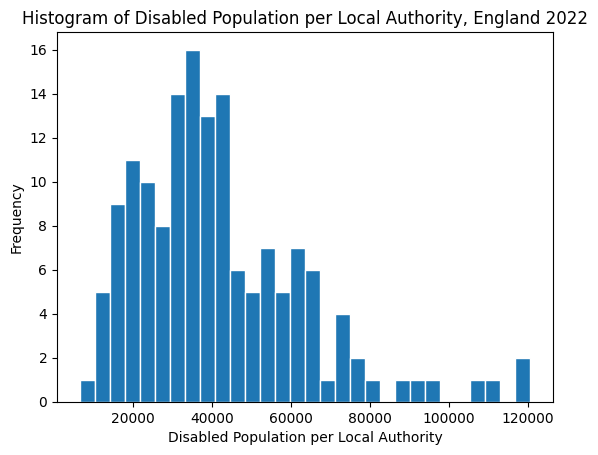

In [175]:
plt.hist(merged_data_no_outliers['Disable_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Disabled Population per Local Authority') # add a label to the x axis
plt.title("Histogram of Disabled Population per Local Authority, England 2022")
plt.show()

## Transport Reliant Population

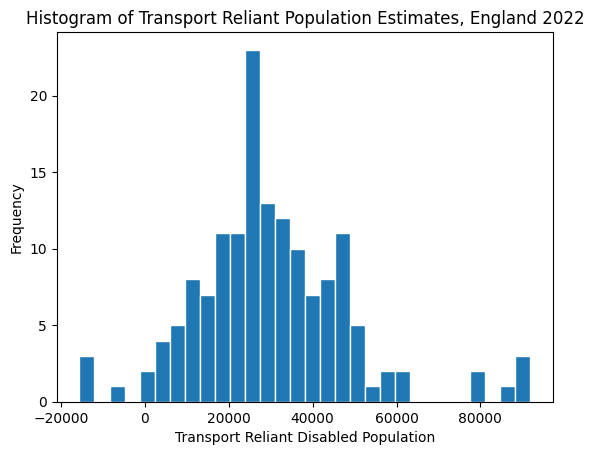

In [176]:
plt.hist(merged_data_no_outliers['Transport_reliant_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Transport Reliant Disabled Population') # add a label to the x axis
plt.title("Histogram of Transport Reliant Population Estimates, England 2022")
plt.show()

## Blue Badges Held

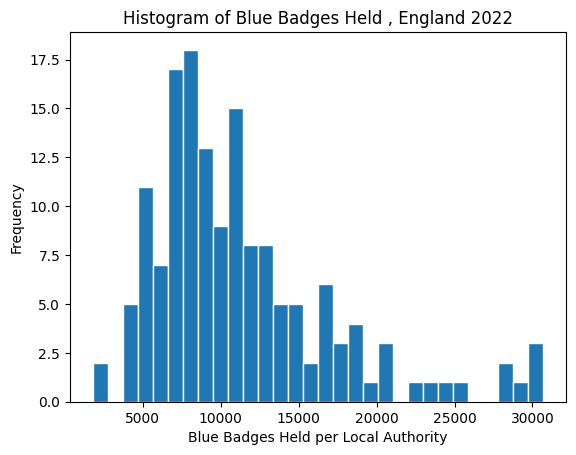

In [177]:
plt.hist(merged_data_no_outliers['Blue_Badges_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Blue Badges Held per Local Authority') # add a label to the x axis
plt.title("Histogram of Blue Badges Held , England 2022")
plt.show()

# Simple Regression Analysis

# Transport Reliant Population VS Total Disabled Population per Local Authority

Text(0.5, 1.0, 'Regression of Transport Reliant Disabled Population on Disabled Population per Local Authority (England, 2022)')

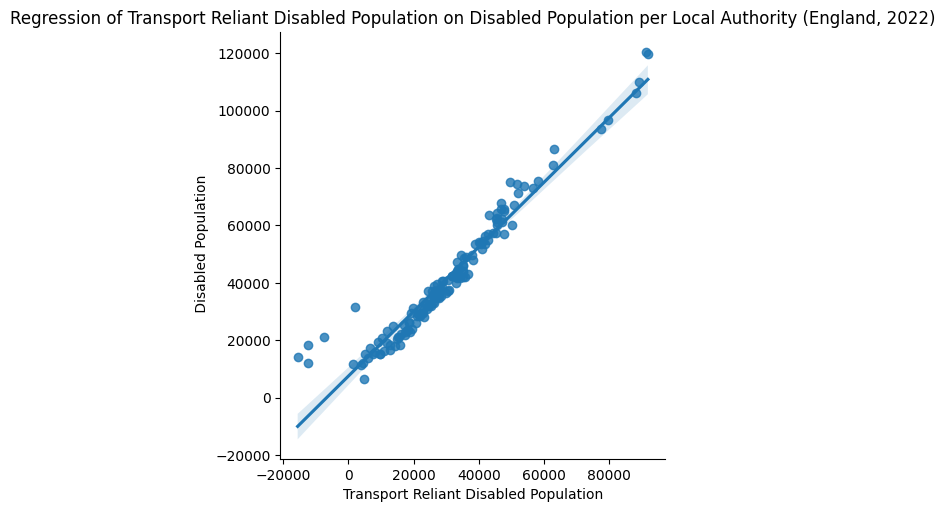

In [178]:
# Generate the scatter plot
sns.lmplot(x='Transport_reliant_population', y='Disable_population', data= merged_data_no_outliers)

plt.xlabel('Transport Reliant Disabled Population')
plt.ylabel(' Disabled Population')

# Display the plot
plt.title('Regression of Transport Reliant Disabled Population on Disabled Population per Local Authority (England, 2022)')

# OLS Regression


### Homoscedasticity test - Breusch-Pagan test

In [179]:
def homoscedasticity_test(lm_results):
    print(lm_results.summary())

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(lm_results.resid, lm_results.model.exog)

    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print("\nBreusch-Pagan test for homoscedasticity:")
    homoscedasticity = False
    for label, value in zip(labels, bp_test):
        print(f"{label}: {value}")
        if label == "F-Test p-value":
            if value > 0.05:
                homoscedasticity = True
    if homoscedasticity:
        print("The regression convey homoscedasticity")
    else:
        print("The regression does not convey homoscedasticity")

Text(0.5, 1.0, 'Regression of Transport Reliant Disabled Population on Disabled Population per Local Authority (England, 2022)')

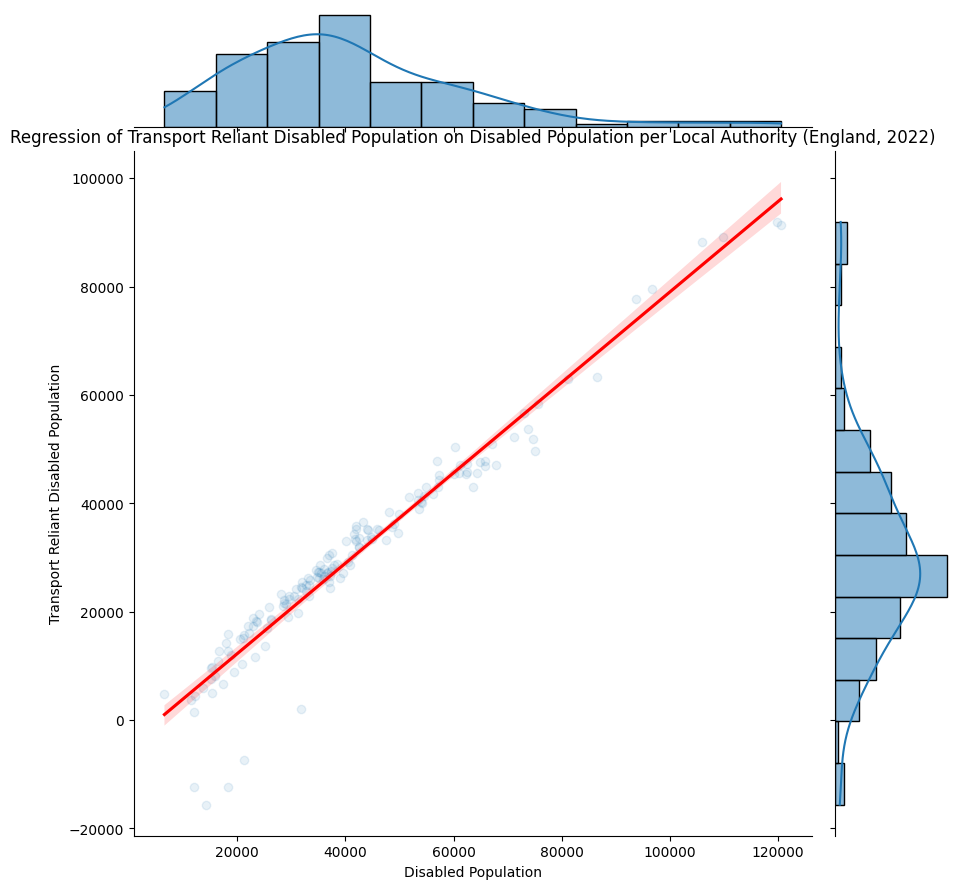

In [180]:
#Homoscedasticity
sns.jointplot(data=merged_data_no_outliers, # plot a scatterplot with a regression line and two histograms
                x='Disable_population', # set the x axis to be the years of schooling
                y='Transport_reliant_population', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=9) # set the height of the plot to be 10 inches

plt.xlabel('Disabled Population') # add a label to the x axis
plt.ylabel('Transport Reliant Disabled Population') # add a label to the y axis
plt.title('Regression of Transport Reliant Disabled Population on Disabled Population per Local Authority (England, 2022)')

In [181]:
from statsmodels.formula.api import ols #the function
from statsmodels.iolib.summary2 import summary_col #to produce a very nice table

model= ols('Transport_reliant_population ~  Disable_population', data=merged_data_no_outliers).fit() # fit the model
print(model.summary()) # print the summary

                                 OLS Regression Results                                 
Dep. Variable:     Transport_reliant_population   R-squared:                       0.937
Model:                                      OLS   Adj. R-squared:                  0.937
Method:                           Least Squares   F-statistic:                     2246.
Date:                          Tue, 16 Jan 2024   Prob (F-statistic):           3.72e-92
Time:                                  10:56:25   Log-Likelihood:                -1498.9
No. Observations:                           152   AIC:                             3002.
Df Residuals:                               150   BIC:                             3008.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [182]:
import statsmodels.formula.api as smf
from scipy import stats
# Fit a linear regression model and store the results in lm_results_1
lm_results_1 = smf.ols('Transport_reliant_population ~  Disable_population', data=merged_data_no_outliers).fit()

homoscedasticity_test(lm_results_1)

                                 OLS Regression Results                                 
Dep. Variable:     Transport_reliant_population   R-squared:                       0.937
Model:                                      OLS   Adj. R-squared:                  0.937
Method:                           Least Squares   F-statistic:                     2246.
Date:                          Tue, 16 Jan 2024   Prob (F-statistic):           3.72e-92
Time:                                  10:56:25   Log-Likelihood:                -1498.9
No. Observations:                           152   AIC:                             3002.
Df Residuals:                               150   BIC:                             3008.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [183]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 4.947847597611243
lm_pvalue = 0.02612317219835892

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan LM Test")
print(bp_lm_test_table)

Results of the Breusch-Pagan LM Test
+----------------+---------------------+
|      Test      |        Value        |
+----------------+---------------------+
| Test Statistic |  4.947847597611243  |
|    p-value     | 0.02612317219835892 |
+----------------+---------------------+


# Visualisations

In [184]:
!pip install geopandas
import geopandas as gpd

# Load the GeoJSON file
geojson_url = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/topo_lad.json'
geo_df = gpd.read_file(geojson_url)
# Check the columns of both dataframes
print(geo_df.columns)
print(merged_data_no_outliers.columns)


Index(['id', 'LAD13CD', 'LAD13CDO', 'LAD13NM', 'LAD13NMW', 'geometry'], dtype='object')
Index(['Local Authority', 'Blue_Badges_population', 'Disable_population',
       'Transport_reliant_population'],
      dtype='object')


In [185]:
geo_df['LAD13NM'] = geo_df['LAD13NM'].astype(str).str.strip()
merged_data_no_outliers['Local Authority'] = merged_data_no_outliers['Local Authority'].astype(str).str.strip()

# Then merge the dataframes on the common key
# 'how' can be 'left', 'right', 'outer', or 'inner' depending on how you want to handle mismatches
merged_geo_data = pd.merge(merged_data_no_outliers, geo_df, left_on='Local Authority', right_on='LAD13NM', how='left')

# Drop the specified columns
merged_geo_data = merged_geo_data.drop(columns=['id', 'LAD13CD', 'LAD13CDO', 'LAD13NM', 'LAD13NMW'])




# Bivariate Choropleth Map

source for colours: https://cran.r-project.org/web/packages/biscale/vignettes/bivariate_palettes.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.get_cmap.html


https://github.com/mikhailsirenko/bivariate-choropleth/blob/main/bivariate-choropleth.ipynb.  


In [186]:
Transport_reliant_population = merged_geo_data['Transport_reliant_population']
Disable_population = merged_geo_data['Disable_population']

In [187]:
#convert into geodataframe
if not isinstance(merged_geo_data, gpd.GeoDataFrame):
    merged_geo_data = gpd.GeoDataFrame(merged_geo_data, geometry='geometry')



<ipython-input-188-cc3ad3497e0d>:28: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



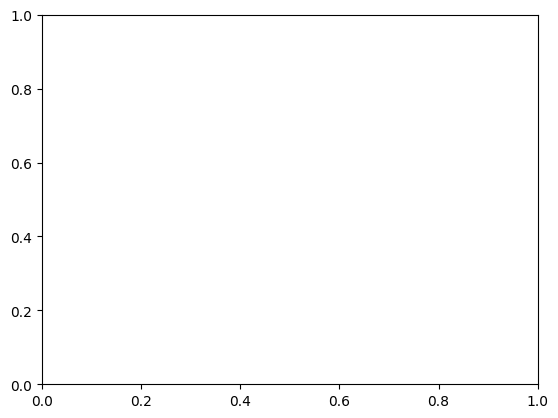

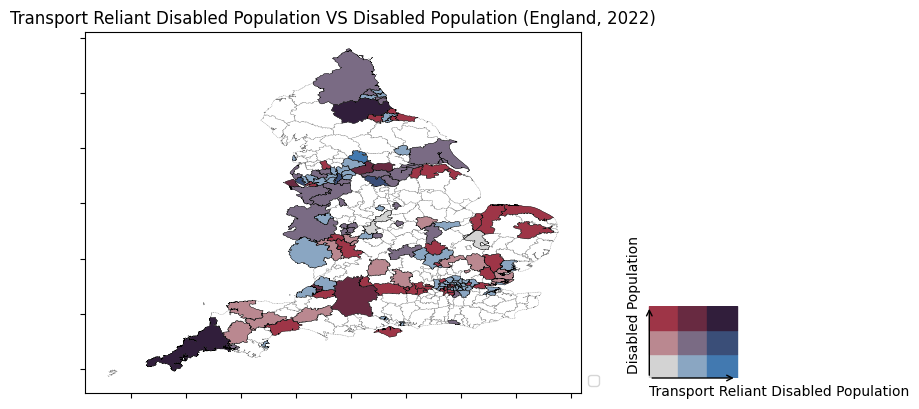

In [188]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
color_sets = {
    'blue-red': [
        # Top row (from left to right)
        '#d3d3d3',  # blue (top left)
        '#ba8890',  # light purple (more blue) (top center)
        '#9e3547',  # purple (top right)

        # Middle row
        '#8aa6c2',  # light blue (middle left)
        '#7a6b84',  # light purple (middle center)
        '#682a41',  # light purple (more blue) (middle right)

        # Bottom row
        '#4279b0',  # light purple (bottom left)
        '#3a4e78',  # light red (bottom center)
        '#311e3b',  # red (bottom right)
    ]
}


# Create figure and axis
fig, ax = plt.subplots(1, 1)

# Define your color set
cmap = plt.cm.get_cmap('RdBu')

# set color
color_set = color_sets['blue-red']


# Normalize the data
transport_norm = ((merged_geo_data['Transport_reliant_population'] - merged_geo_data['Transport_reliant_population'].min()) / (merged_geo_data['Transport_reliant_population'].max() - merged_geo_data['Transport_reliant_population'].min()) * 8).astype(int)
disabled_norm = ((merged_geo_data['Disable_population'] - merged_geo_data['Disable_population'].min()) / (merged_geo_data['Disable_population'].max() - merged_geo_data['Disable_population'].min()) * 8).astype(int)

# Calculate colors for each area
colors = [color_set[max(transport_norm.iloc[i], disabled_norm.iloc[i])] for i in range(len(merged_geo_data))]

# Plot the geometry
merged_geo_data['geometry'].plot(ax=ax, color=colors)

# Add legend
ax2 = fig.add_axes([1, 0.15, 0.15, 0.15])
for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=1, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Transport Reliant Disabled Population', x=0, y=-0.25)
ax2.text(s='Disabled Population', x=-0.25, y=0.1, rotation=90)
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

geo_df.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.25, linestyle='--')
merged_geo_data.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)

merged_geo_data.plot(ax=ax, color=colors)
ax.set_title('Transport Reliant Disabled Population VS Disabled Population (England, 2022)')
ax.set_xticklabels([])
ax.set_yticklabels([])
# Show the plot
plt.show()

<ipython-input-189-a380e221542e>:40: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



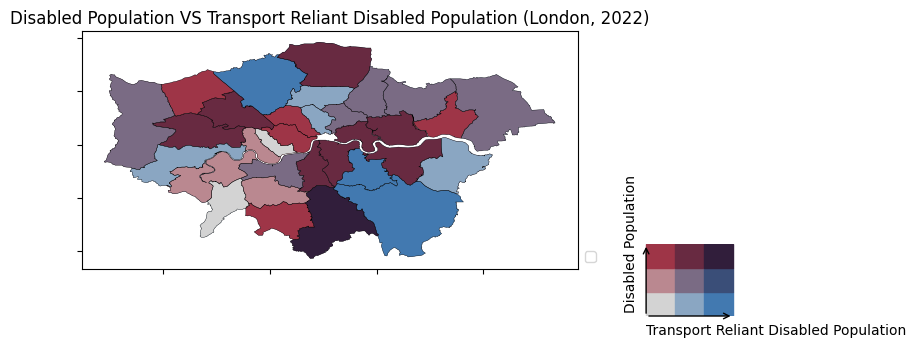

<function print>

In [189]:
london_boroughs = [
    'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden',
    'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham',
    'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
    'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham',
    'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark',
    'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'
]

merged_geo_data_london = merged_geo_data[merged_geo_data['Local Authority'].isin(london_boroughs)]
geo_df_london = geo_df[geo_df['LAD13NM'].isin(london_boroughs)]


fig, ax = plt.subplots(1, 1)
merged_geo_data_london.plot(ax=ax, color=colors)




color_sets = {
    'blue-red': [
        # Top row (from left to right)
        '#d3d3d3',  # blue (top left)
        '#ba8890',  # light purple (more blue) (top center)
        '#9e3547',  # purple (top right)

        # Middle row
        '#8aa6c2',  # light blue (middle left)
        '#7a6b84',  # light purple (middle center)
        '#682a41',  # light purple (more blue) (middle right)

        # Bottom row
        '#4279b0',  # light purple (bottom left)
        '#3a4e78',  # light red (bottom center)
        '#311e3b',  # red (bottom right)
    ]
}

#Define your color set
cmap = plt.cm.get_cmap('RdBu')

color_set = color_sets['blue-red']


# Normalize the data
transport_norm = ((merged_geo_data_london['Transport_reliant_population'] - merged_geo_data_london['Transport_reliant_population'].min()) / (merged_geo_data_london['Transport_reliant_population'].max() - merged_geo_data_london['Transport_reliant_population'].min()) * 8).astype(int)
disabled_norm = ((merged_geo_data_london['Disable_population'] - merged_geo_data_london['Disable_population'].min()) / (merged_geo_data_london['Disable_population'].max() - merged_geo_data_london['Disable_population'].min()) * 8).astype(int)

# Calculate colors for each area
colors = [color_set[max(transport_norm.iloc[i], disabled_norm.iloc[i])] for i in range(len(merged_geo_data_london))]

# Plot the geometry
merged_geo_data_london['geometry'].plot(ax=ax, color=colors)

# Add legend
ax2 = fig.add_axes([1, 0.15, 0.15, 0.15])
for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=1, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Transport Reliant Disabled Population', x=0, y=-0.25)
ax2.text(s='Disabled Population', x=-0.25, y=0.1, rotation=90)
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

merged_geo_data_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Disabled Population VS Transport Reliant Disabled Population (London, 2022)')

# Show the plot
plt.show()

print


# Disability and deprivation

In [190]:
#add deprivation and total population data
url = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/Deprivation_per_borough.csv'
imd_df = pd.read_csv(url, delimiter=',')
imd_df.columns = imd_df.columns.str.strip()
imd_score = imd_df[['Local Authority District name (2019)', 'IMD - Average score']].copy()

merged_geo_data_imd_london= pd.merge(merged_geo_data_london, imd_score, left_on='Local Authority', right_on='Local Authority District name (2019)', how='inner')





In [191]:
url = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/London%20Borough%20Population%20Final%20.csv'
pop_df = pd.read_csv(url, delimiter=',')
pop_df.columns = pop_df.columns.str.strip()





In [192]:

# Adjust the column names in the merge operation
merged_geo_data_imd_pop_london = pd.merge(merged_geo_data_imd_london, pop_df, left_on='Local Authority', right_on='London Borough', how='inner')


merged_geo_data_imd_pop_london.drop(['Local Authority District name (2019)', 'London Borough', 'Unnamed: 2', 'Unnamed: 3','Unnamed: 4' ], axis=1, inplace=True)
# Replace apostrophes and convert to integers
merged_geo_data_imd_pop_london['Population'] = merged_geo_data_imd_pop_london['Population'].str.replace("'", "").astype(int)

merged_geo_data_imd_pop_london['Population'] = pd.to_numeric(merged_geo_data_imd_pop_london['Population'], errors='coerce')


In [193]:
merged_geo_data_imd_pop_london['Population'] = pd.to_numeric(merged_geo_data_imd_pop_london['Population'], errors='coerce')

# Create new column 'Blue_badges_density'
merged_geo_data_imd_pop_london['Blue_badges_density'] = merged_geo_data_imd_pop_london['Blue_Badges_population'] / merged_geo_data_imd_pop_london['Population']

# Create new column 'Transport_reliant_density'
merged_geo_data_imd_pop_london['Transport_reliant_density'] = merged_geo_data_imd_pop_london['Transport_reliant_population'] / merged_geo_data_imd_pop_london['Population']



## Regressions: Blue Badges Density VS Deprivation Index

In [194]:
#SUMMARY STATISTICS
summary=merged_geo_data_imd_pop_london.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary
# Setup the PrettyTable
table = PrettyTable()
table.field_names = ["Variable", "Mean", "St. Dev.", "Min", "25%", "50%", "75%", "Max"]
table.title = "Summary Statistics"

# Add data to the table
for row in summary.iterrows():
    table.add_row([row[0], row[1]["mean"], row[1]["std"], row[1]["min"], row[1]["25%"], row[1]["50%"], row[1]["75%"], row[1]["max"]])

# Print the table
print(table)


+--------------------------------------------------------------------------------------------------------------+
|                                              Summary Statistics                                              |
+------------------------------+-----------+----------+----------+-----------+----------+-----------+----------+
|           Variable           |    Mean   | St. Dev. |   Min    |    25%    |   50%    |    75%    |   Max    |
+------------------------------+-----------+----------+----------+-----------+----------+-----------+----------+
|    Blue_Badges_population    |  8076.88  | 2798.59  |  2442.0  |  6524.25  |  7405.5  |  9879.25  | 15231.0  |
|      Disable_population      |  36360.47 | 8389.73  | 18311.0  |  30847.0  | 37021.0  |  42018.25 | 54852.0  |
| Transport_reliant_population |  28283.59 | 6504.27  | 15869.0  |  23052.25 | 28210.5  |  33577.0  | 42952.0  |
|     IMD - Average score      |    21.5   |   6.06   |   9.4    |   16.53   |   21.9   |    25.

Text(0.5, 1.0, 'Regression of IMD Score on Proportion of Blue Badges Held per Borough (London, 2022)')

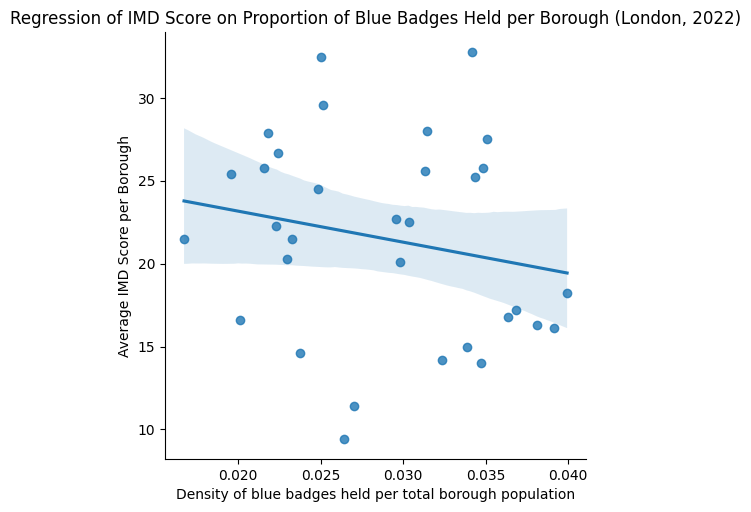

In [195]:
#SCATTERPLOT
# Generate the scatter plot
sns.lmplot(x='Blue_badges_density', y='IMD - Average score', data= merged_geo_data_imd_pop_london)

plt.xlabel('Density of blue badges held per total borough population')
plt.ylabel('Average IMD Score per Borough')

# Display the plot
plt.title('Regression of IMD Score on Proportion of Blue Badges Held per Borough (London, 2022)')  # plot title


Text(0.5, 1.0, 'Regression of IMD Score on Proportion of Blue Badges Held per Borough (London, 2022)')

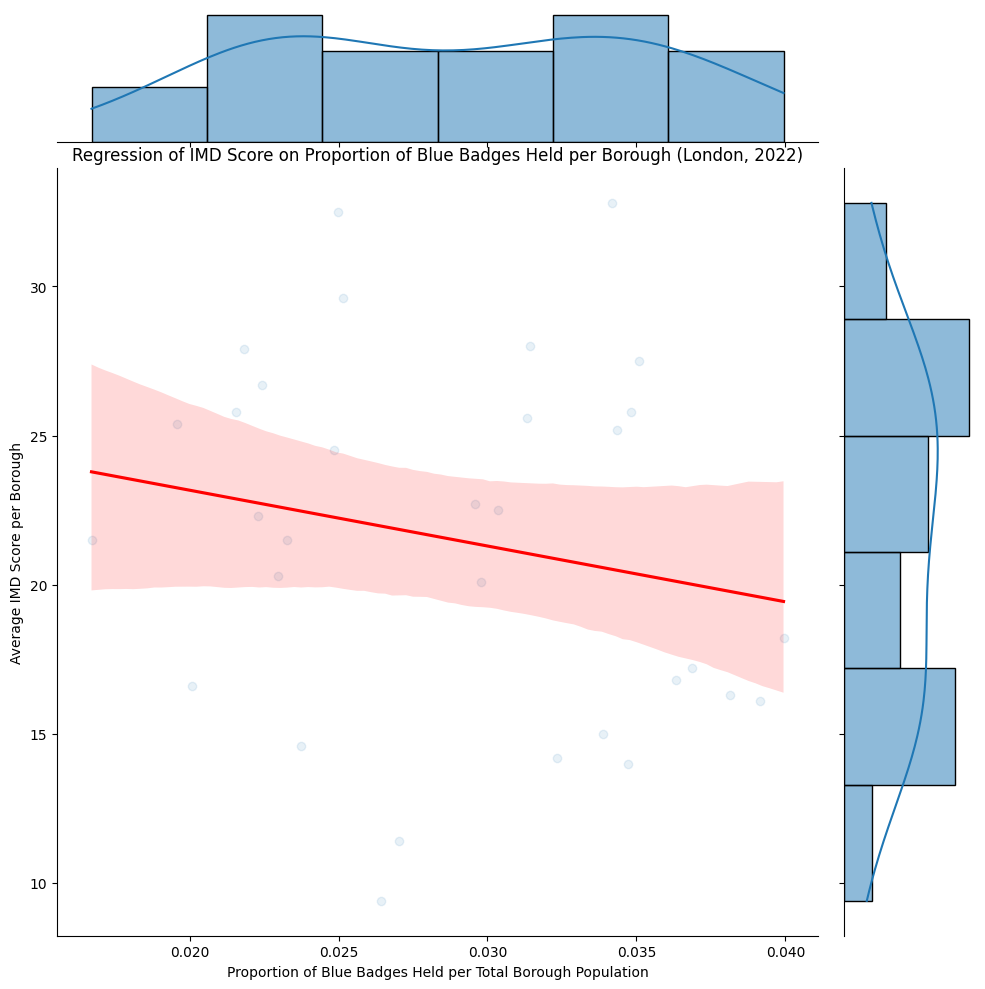

In [196]:
def homoscedasticity_test(lm_results):
    print(lm_results.summary())

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(lm_results.resid, lm_results.model.exog)

    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print("\nBreusch-Pagan test for homoscedasticity:")
    homoscedasticity = False
    for label, value in zip(labels, bp_test):
        print(f"{label}: {value}")
        if label == "F-Test p-value":
            if value > 0.05:
                homoscedasticity = True
    if homoscedasticity:
        print("The regression convey homoscedasticity")
    else:
        print("The regression does not convey homoscedasticity")


#Homoscedasticity
sns.jointplot(data=merged_geo_data_imd_pop_london, # plot a scatterplot with a regression line and two histograms
                x='Blue_badges_density', # set the x axis to be the years of schooling
                y='IMD - Average score', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Proportion of Blue Badges Held per Total Borough Population') # add a label to the x axis
plt.ylabel('Average IMD Score per Borough') # add a label to the y axis
plt.title('Regression of IMD Score on Proportion of Blue Badges Held per Borough (London, 2022)')  # plot title


In [197]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

# Note the use of `Q()` around the column name with a hyphen
model = ols('Blue_badges_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()
print(model.summary())

import statsmodels.formula.api as smf
from scipy import stats

# Again, use `Q()` for the column name
lm_results_1 = smf.ols('Blue_badges_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()

# Assuming you have a function defined for homoscedasticity_test
homoscedasticity_test(lm_results_1)


                             OLS Regression Results                            
Dep. Variable:     Blue_badges_density   R-squared:                       0.040
Model:                             OLS   Adj. R-squared:                  0.008
Method:                  Least Squares   F-statistic:                     1.249
Date:                 Tue, 16 Jan 2024   Prob (F-statistic):              0.273
Time:                         10:56:38   Log-Likelihood:                 117.03
No. Observations:                   32   AIC:                            -230.1
Df Residuals:                       30   BIC:                            -227.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

In [198]:

from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 4.947847597611243
lm_pvalue = 0.02612317219835892

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan LM Test")
print(bp_lm_test_table)

Results of the Breusch-Pagan LM Test
+----------------+---------------------+
|      Test      |        Value        |
+----------------+---------------------+
| Test Statistic |  4.947847597611243  |
|    p-value     | 0.02612317219835892 |
+----------------+---------------------+


<ipython-input-199-4319e2deca62>:30: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



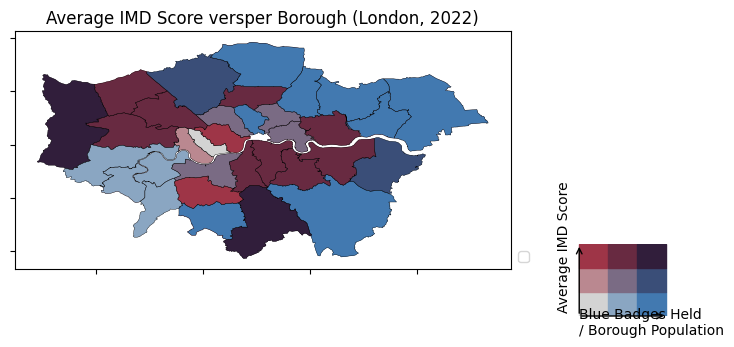

<function print>

In [199]:
#VISUALISATION

fig, ax = plt.subplots(1, 1)
merged_geo_data_imd_pop_london.plot(ax=ax, color=colors)

model = ols('Blue_badges_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()



color_sets = {
    'blue-red': [
        # Top row (from left to right)
        '#d3d3d3',  # blue (top left)
        '#ba8890',  # light purple (more blue) (top center)
        '#9e3547',  # purple (top right)

        # Middle row
        '#8aa6c2',  # light blue (middle left)
        '#7a6b84',  # light purple (middle center)
        '#682a41',  # light purple (more blue) (middle right)

        # Bottom row
        '#4279b0',  # light purple (bottom left)
        '#3a4e78',  # light red (bottom center)
        '#311e3b',  # red (bottom right)
    ]
}

#Define your color set
cmap = plt.cm.get_cmap('RdBu')

color_set = color_sets['blue-red']


# Normalize the data
transport_norm = ((merged_geo_data_imd_pop_london['Blue_badges_density'] - merged_geo_data_imd_pop_london['Blue_badges_density'].min()) / (merged_geo_data_imd_pop_london['Blue_badges_density'].max() - merged_geo_data_imd_pop_london['Blue_badges_density'].min()) * 8).astype(int)
deprivation_norm = ((merged_geo_data_imd_pop_london['IMD - Average score'] - merged_geo_data_imd_pop_london['IMD - Average score'].min()) / (merged_geo_data_imd_pop_london['IMD - Average score'].max() - merged_geo_data_imd_pop_london['IMD - Average score'].min()) * 8).astype(int)

# Calculate colors for each area
colors = [color_set[max(transport_norm.iloc[i], disabled_norm.iloc[i])] for i in range(len(merged_geo_data_imd_pop_london))]

# Plot the geometry
merged_geo_data_imd_pop_london['geometry'].plot(ax=ax, color=colors)

# Add legend
ax2 = fig.add_axes([1, 0.15, 0.15, 0.15])
for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=1, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Blue Badges Held \n/ Borough Population', x=0, y=-0.25)
ax2.text(s='Average IMD Score', x=-0.25, y=0.1, rotation=90)
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
ax.set_xticklabels([])
ax.set_yticklabels([])
merged_geo_data_imd_pop_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)
ax.set_title('Average IMD Score versper Borough (London, 2022)')



# Show the plot
plt.show()

print


##Regressions: Blue Badges Density VS Deprivation Index

Text(0.5, 1.0, 'Regression of IMD Score on Proportion of Transport Reliant Disabled People per Borough (London, 2022)')

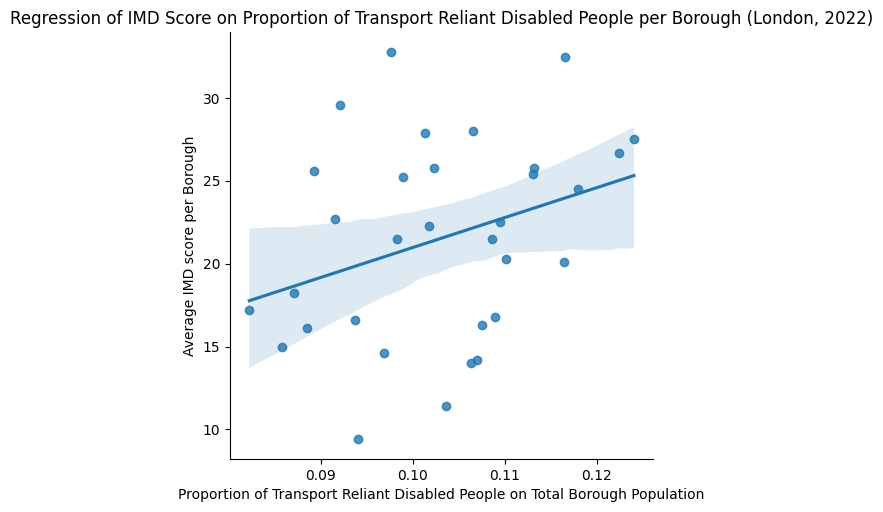

In [200]:
# Generate the scatter plot
sns.lmplot(x='Transport_reliant_density', y='IMD - Average score', data= merged_geo_data_imd_pop_london)

plt.xlabel('Proportion of Transport Reliant Disabled People on Total Borough Population')
plt.ylabel('Average IMD score per Borough')

# Display the plot
plt.title('Regression of IMD Score on Proportion of Transport Reliant Disabled People per Borough (London, 2022)')  # plot title


Text(0.5, 1.0, 'Regression of IMD Score on Proportion of Transport Reliant Disabled People per Borough (London, 2022)')

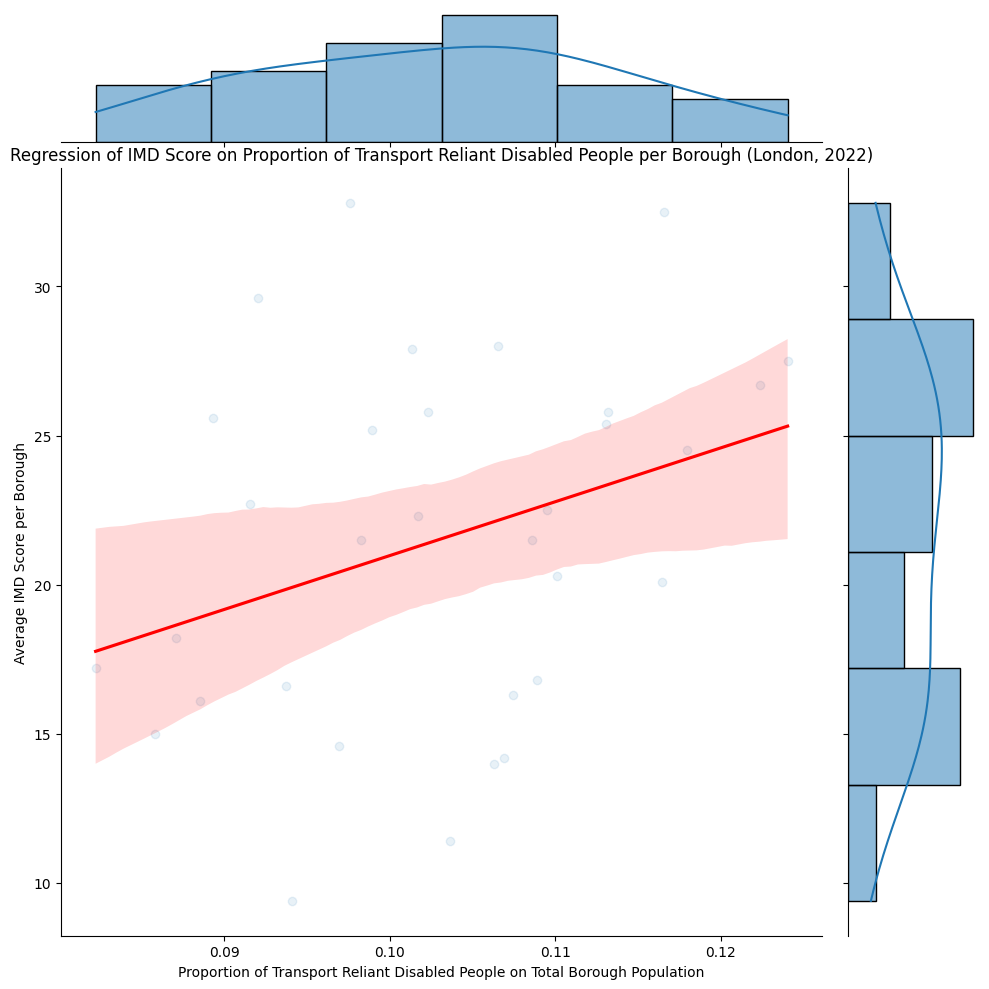

In [201]:
def homoscedasticity_test(lm_results):
    print(lm_results.summary())

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(lm_results.resid, lm_results.model.exog)

    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print("\nBreusch-Pagan test for homoscedasticity:")
    homoscedasticity = False
    for label, value in zip(labels, bp_test):
        print(f"{label}: {value}")
        if label == "F-Test p-value":
            if value > 0.05:
                homoscedasticity = True
    if homoscedasticity:
        print("The regression convey homoscedasticity")
    else:
        print("The regression does not convey homoscedasticity")


#Homoscedasticity
sns.jointplot(data=merged_geo_data_imd_pop_london, # plot a scatterplot with a regression line and two histograms
                x='Transport_reliant_density', # set the x axis to be the years of schooling
                y='IMD - Average score', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Proportion of Transport Reliant Disabled People on Total Borough Population') # add a label to the x axis
plt.ylabel('Average IMD Score per Borough') # add a label to the y axis
plt.title('Regression of IMD Score on Proportion of Transport Reliant Disabled People per Borough (London, 2022)')  # plot title


In [202]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

# Note the use of `Q()` around the column name with a hyphen
model = ols('Transport_reliant_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()
print(model.summary())

import statsmodels.formula.api as smf
from scipy import stats

# Again, use `Q()` for the column name
lm_results_1 = smf.ols('Transport_reliant_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()

# Assuming you have a function defined for homoscedasticity_test
homoscedasticity_test(lm_results_1)

                                OLS Regression Results                               
Dep. Variable:     Transport_reliant_density   R-squared:                       0.107
Model:                                   OLS   Adj. R-squared:                  0.077
Method:                        Least Squares   F-statistic:                     3.593
Date:                       Tue, 16 Jan 2024   Prob (F-statistic):             0.0677
Time:                               10:56:41   Log-Likelihood:                 101.30
No. Observations:                         32   AIC:                            -198.6
Df Residuals:                             30   BIC:                            -195.7
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [203]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 4.947847597611243
lm_pvalue = 0.02612317219835892

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan LM Test")
print(bp_lm_test_table)

Results of the Breusch-Pagan LM Test
+----------------+---------------------+
|      Test      |        Value        |
+----------------+---------------------+
| Test Statistic |  4.947847597611243  |
|    p-value     | 0.02612317219835892 |
+----------------+---------------------+


<Axes: title={'center': 'Average IMD Score per Borough (London, 2022)'}>

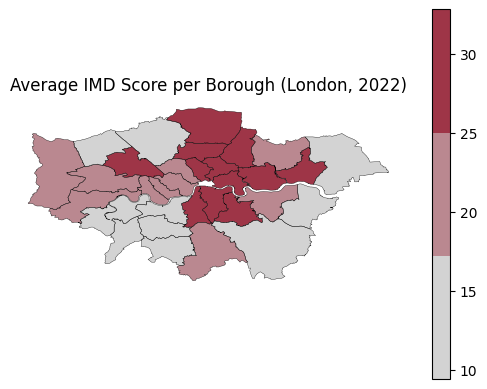

In [204]:
#CHOROPLETH VARIABLE: IMD-Average Score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define your color set for the single variable
color_set = ['#d3d3d3', '#ba8890', '#9e3547']

# Create a custom color map
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", color_set, N=3)

# Normalize the 'IMD - Average Score' data
deprivation_norm = ((merged_geo_data_imd_pop_london['IMD - Average score'] - merged_geo_data_imd_pop_london['IMD - Average score'].min()) / (merged_geo_data_imd_pop_london['IMD - Average score'].max() - merged_geo_data_imd_pop_london['IMD - Average score'].min()) * 2).astype(int)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1)
merged_geo_data_imd_pop_london.plot(ax=ax, column='IMD - Average score', cmap=cmap, legend=True)

# Normalize the legend
sm = plt
# Set the title and other plot settings
ax.set_title('Average IMD Score per Borough (London, 2022)')
ax.axis('off')  # Turn off the axis

merged_geo_data_imd_pop_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)



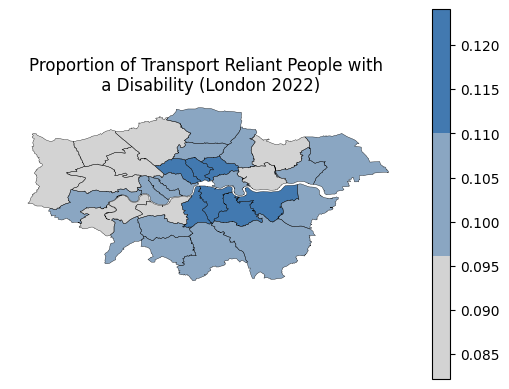

In [205]:
#CHOROPLETH VARIABLE: Density of Transport Reliant People Density
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define your color set for the 'Transport_reliant_density' variable
color_set = ['#d3d3d3', '#8aa6c2', '#4279b0']  # The colors you specified

# Create a custom color map
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", color_set, N=3)

# Normalize the 'Transport_reliant_density' data
transport_norm = ((merged_geo_data_imd_pop_london['Transport_reliant_density'] - merged_geo_data_imd_pop_london['Transport_reliant_density'].min()) / (merged_geo_data_imd_pop_london['Transport_reliant_density'].max() - merged_geo_data_imd_pop_london['Transport_reliant_density'].min()) * 2).astype(int)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1)
merged_geo_data_imd_pop_london.plot(ax=ax, column='Transport_reliant_density', cmap=cmap, legend=True)

# Normalize the legend

# Set the title and other plot settings
ax.set_title('Proportion of Transport Reliant People with \n a Disability (London 2022)')
ax.axis('off')  # Turn off the axis

merged_geo_data_imd_pop_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)

# Show the plot
plt.show()



<ipython-input-206-6d4134048f27>:30: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



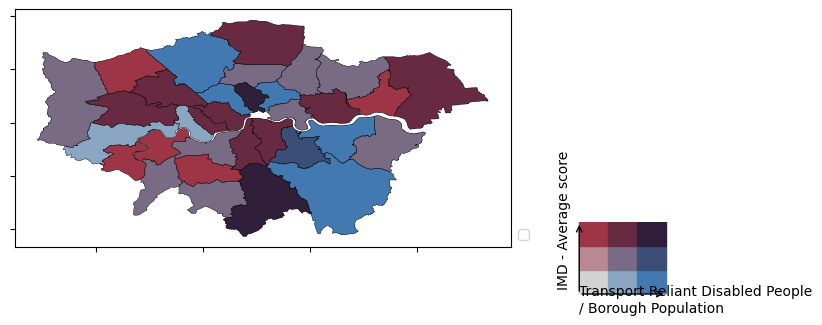

<function print>

In [206]:
#VISUALISATION

fig, ax = plt.subplots(1, 1)
merged_geo_data_imd_pop_london.plot(ax=ax, color=colors)

model = ols('Transport_reliant_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()



color_sets = {
    'blue-red': [
        # Top row (from left to right)
        '#d3d3d3',  # blue (top left)
        '#ba8890',  # light purple (more blue) (top center)
        '#9e3547',  # purple (top right)

        # Middle row
        '#8aa6c2',  # light blue (middle left)
        '#7a6b84',  # light purple (middle center)
        '#682a41',  # light purple (more blue) (middle right)

        # Bottom row
        '#4279b0',  # light purple (bottom left)
        '#3a4e78',  # light red (bottom center)
        '#311e3b',  # red (bottom right)
    ]
}

#Define your color set
cmap = plt.cm.get_cmap('RdBu')

color_set = color_sets['blue-red']


# Normalize the data
transport_norm = ((merged_geo_data_imd_pop_london['Transport_reliant_density'] - merged_geo_data_imd_pop_london['Transport_reliant_density'].min()) / (merged_geo_data_imd_pop_london['Transport_reliant_density'].max() - merged_geo_data_imd_pop_london['Transport_reliant_density'].min()) * 8).astype(int)
deprivation_norm = ((merged_geo_data_imd_pop_london['IMD - Average score'] - merged_geo_data_imd_pop_london['IMD - Average score'].min()) / (merged_geo_data_imd_pop_london['IMD - Average score'].max() - merged_geo_data_imd_pop_london['IMD - Average score'].min()) * 8).astype(int)

# Calculate colors for each area
colors = [color_set[max(transport_norm.iloc[i], disabled_norm.iloc[i])] for i in range(len(merged_geo_data_imd_pop_london))]

# Plot the geometry
merged_geo_data_imd_pop_london['geometry'].plot(ax=ax, color=colors)

# Add legend
ax2 = fig.add_axes([1, 0.15, 0.15, 0.15])
for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=1, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Transport Reliant Disabled People\n/ Borough Population', x=0, y=-0.25)
ax2.text(s='IMD - Average score', x=-0.25, y=0.1, rotation=90)
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
ax.set_xticklabels([])
ax.set_yticklabels([])

merged_geo_data_imd_pop_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)




# Show the plot
plt.show()

print


# Density of Blue Badges VS Deprivation VS Accessibility

In [207]:
import pandas as pd

url = "https://raw.githubusercontent.com/bofeng2268/qm2/main/Accesibility%20score%20per%20borough.csv"
accessibility_data = pd.read_csv(url, sep=';')

accessibility_data.rename(columns={'Accesibility Score': 'Accessibility Score'}, inplace=True)
accessibility_data.rename(columns={'Borough': 'Local Authority'}, inplace=True)


accessibility_data['Accessibility Score'] = accessibility_data['Accessibility Score'].str.replace(',', '.')

# Convert the 'Accessibility Score' column to numerical type
accessibility_data['Accessibility Score'] = pd.to_numeric(accessibility_data['Accessibility Score'])


merged_geo_data_imd_pop_acc_london = pd.merge(merged_geo_data_imd_pop_london, accessibility_data[['Local Authority', 'Accessibility Score']], on='Local Authority')




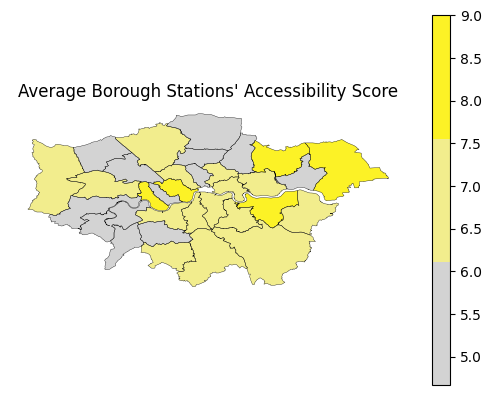

In [208]:
#CHROPLETH MAP VARIABLE: Accessibility Score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Define your color set for the 'Accessibility Score' variable
color_set = ['#d3d3d3', '#f2ed8d', '#fcf226']  # The colors you specified

# Create a custom color map
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", color_set, N=3)

# Normalize the 'Transport_reliant_density' data
accessibility_norm = ((merged_geo_data_imd_pop_acc_london['Accessibility Score'] - merged_geo_data_imd_pop_acc_london['Accessibility Score'].min()) / (merged_geo_data_imd_pop_acc_london['Accessibility Score'].max() - merged_geo_data_imd_pop_acc_london['Accessibility Score'].min()) * 2).astype(int)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1)
merged_geo_data_imd_pop_acc_london.plot(ax=ax, column='Accessibility Score', cmap=cmap, legend=True)

# Normalize the legend

# Set the title and other plot settings
ax.set_title("Average Borough Stations' Accessibility Score")
ax.axis('off')  # Turn off the axis

merged_geo_data_imd_pop_acc_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)

# Show the plot
plt.show()

In [209]:
#SCALE 3 VARIABLES DATA FOR REGRESSION
columns_to_standardise = ['Accessibility Score', 'IMD - Average score', 'Transport_reliant_density']

scaler = StandardScaler()
merged_geo_data_imd_pop_acc_london[columns_to_standardise] = scaler.fit_transform(merged_geo_data_imd_pop_acc_london[columns_to_standardise])
merged_geo_data_imd_pop_acc_london = merged_geo_data_imd_pop_acc_london.rename(columns = {'Accessibility Score':'accessibility_scaled'})
merged_geo_data_imd_pop_acc_london = merged_geo_data_imd_pop_acc_london.rename(columns = {'IMD - Average score':'imd_scaled'})
merged_geo_data_imd_pop_acc_london = merged_geo_data_imd_pop_acc_london.rename(columns = {'Transport_reliant_density':'Transport_reliant_density_scaled'})

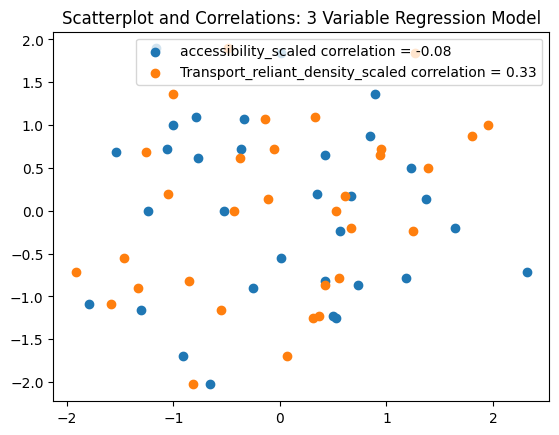

In [210]:
## REGRESSION
regression_3 = merged_geo_data_imd_pop_acc_london[['Local Authority', 'Transport_reliant_density_scaled', 'imd_scaled', 'accessibility_scaled']]
regression_3.head()


x1 = 'accessibility_scaled'
x2 = 'Transport_reliant_density_scaled'
x3 = 'imd_scaled'


plt.scatter(regression_3['accessibility_scaled'], regression_3['imd_scaled'], label=f'{x1} correlation = {np.round(np.corrcoef(regression_3["imd_scaled"], regression_3["accessibility_scaled"])[0, 1], 2)}')
plt.scatter(regression_3['Transport_reliant_density_scaled'], regression_3['imd_scaled'], label=f'{x2} correlation = {np.round(np.corrcoef(regression_3["imd_scaled"], regression_3["Transport_reliant_density_scaled"])[0, 1], 2)}')

plt.title('Scatterplot and Correlations: 3 Variable Regression Model')
plt.legend()
plt.show()

In [211]:

lm_3_results = smf.ols('imd_scaled ~ accessibility_scaled + Transport_reliant_density_scaled', data=merged_geo_data_imd_pop_acc_london).fit()

homoscedasticity_test(lm_3_results)

                            OLS Regression Results                            
Dep. Variable:             imd_scaled   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.109
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.140
Time:                        10:56:45   Log-Likelihood:                -43.234
No. Observations:                  32   AIC:                             92.47
Df Residuals:                      29   BIC:                             96.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [212]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 2.2947138530826194
lm_pvalue = 0.3174747705817681

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan LM Test")
print(bp_lm_test_table)

Results of the Breusch-Pagan LM Test
+----------------+--------------------+
|      Test      |       Value        |
+----------------+--------------------+
| Test Statistic | 2.2947138530826194 |
|    p-value     | 0.3174747705817681 |
+----------------+--------------------+


## OLS Regression 3 Variables

*  on previous model 'Model 3 Variables'



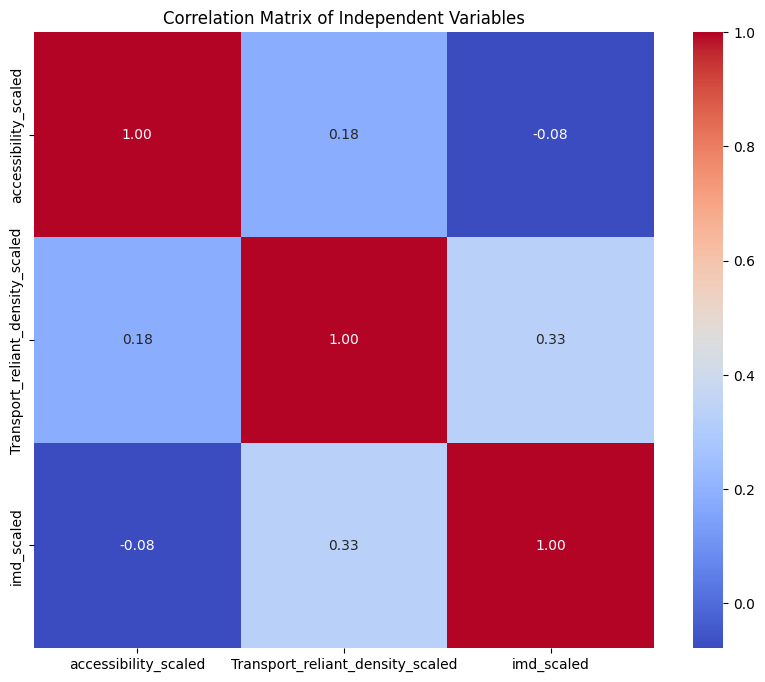

In [213]:
# Select the independent variables used in the regression model
independent_vars = merged_geo_data_imd_pop_acc_london[['accessibility_scaled', 'Transport_reliant_density_scaled', 'imd_scaled']]

# Calculate the correlation matrix
correlation_matrix = independent_vars.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Size of the figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Independent Variables')
plt.show()


In [214]:
# Define a function to calculate VIF for each independent variable and drop those with high VIF
def drop_column_using_vif(data, thresh=5.0):
    max_vif_value = 0  # Variable to store the maximum VIF value
    while True:
        # The independent variables are scaled, so we need to add a constant for VIF calculation
        data_with_const = add_constant(data)

        # Calculate VIFs
        vif_df = pd.DataFrame({
            'VIF': [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])],
            'variable': data_with_const.columns
        })

        # Drop the entry for the constant
        vif_df = vif_df[vif_df['variable'] != 'const']

        # Find the maximum VIF value among the variables
        max_vif = vif_df['VIF'].max()
        max_vif_value = max(max_vif, max_vif_value)  # Update the maximum VIF value if the current one is higher

        if max_vif > thresh:
            # If the maximum VIF value is above the threshold, drop that variable
            variable_to_drop = vif_df[vif_df['VIF'] == max_vif]['variable'].values[0]
            print(f"Dropping '{variable_to_drop}' with VIF {max_vif}")
            data = data.drop(columns=variable_to_drop)
        else:
            break

    return data, max_vif_value  # Return the dataframe and the maximum VIF value

# Apply the function to the selected independent variables
reduced_vars, max_vif = drop_column_using_vif(independent_vars)

# Print the remaining variables and the maximum VIF value
print("Columns after VIF selection:", reduced_vars.columns)
print("Maximum VIF value:", max_vif)

Columns after VIF selection: Index(['accessibility_scaled', 'Transport_reliant_density_scaled',
       'imd_scaled'],
      dtype='object')
Maximum VIF value: 1.1785284877723405


In [215]:
# Create an instance of PrettyTable
table = PrettyTable()

# Define the column names
table.field_names = ["VIF analysis", "Outcome"]

# Add rows to the table with the data
table.add_row(["Remaining columns after VIF selection", "accessibility_scaled, Transport_reliant_density_scaled, imd_scaled"])
table.add_row(["Maximum VIF value", "1.1785284877723405"])

# Print the table
print(table)

+---------------------------------------+--------------------------------------------------------------------+
|              VIF analysis             |                              Outcome                               |
+---------------------------------------+--------------------------------------------------------------------+
| Remaining columns after VIF selection | accessibility_scaled, Transport_reliant_density_scaled, imd_scaled |
|           Maximum VIF value           |                         1.1785284877723405                         |
+---------------------------------------+--------------------------------------------------------------------+


<ipython-input-216-8c50ad26bf4e>:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



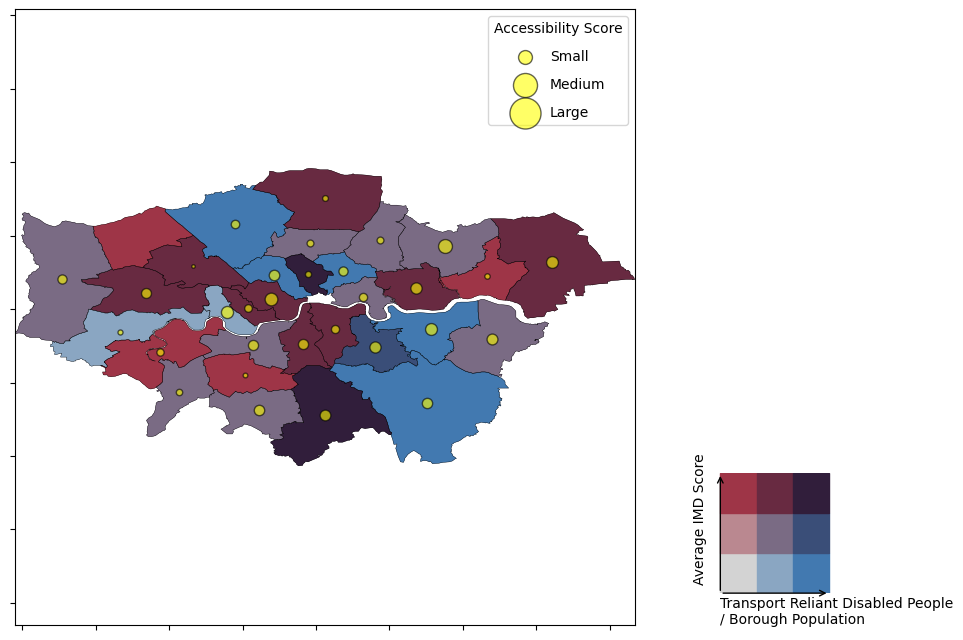

<function print>

In [216]:
import matplotlib.pyplot as plt
import geopandas as gpd
from statsmodels.formula.api import ols


fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figsize as needed
ax.set_aspect('equal', adjustable='datalim')
ax.margins(0)

merged_geo_data_imd_pop_acc_london.plot(ax=ax, color=colors)
model = ols('Transport_reliant_density_scaled ~ imd_scaled', data=merged_geo_data_imd_pop_acc_london).fit()



color_sets = {
    'blue-red': [
        # Top row (from left to right)
        '#d3d3d3',  # blue (top left)
        '#ba8890',  # light purple (more blue) (top center)
        '#9e3547',  # purple (top right)

        # Middle row
        '#8aa6c2',  # light blue (middle left)
        '#7a6b84',  # light purple (middle center)
        '#682a41',  # light purple (more blue) (middle right)

        # Bottom row
        '#4279b0',  # light purple (bottom left)
        '#3a4e78',  # light red (bottom center)
        '#311e3b',  # red (bottom right)
    ]
}

#Define your color set
cmap = plt.cm.get_cmap('RdBu')

color_set = color_sets['blue-red']


# Normalize the data
transport_norm = ((merged_geo_data_imd_pop_acc_london['Transport_reliant_density_scaled'] - merged_geo_data_imd_pop_acc_london['Transport_reliant_density_scaled'].min()) / (merged_geo_data_imd_pop_acc_london['Transport_reliant_density_scaled'].max() - merged_geo_data_imd_pop_acc_london['Transport_reliant_density_scaled'].min()) * 8).astype(int)
deprivation_norm = ((merged_geo_data_imd_pop_acc_london['imd_scaled'] - merged_geo_data_imd_pop_acc_london['imd_scaled'].min()) / (merged_geo_data_imd_pop_acc_london['imd_scaled'].max() - merged_geo_data_imd_pop_acc_london['imd_scaled'].min()) * 8).astype(int)
accessibility_norm = ((merged_geo_data_imd_pop_acc_london['accessibility_scaled'] - merged_geo_data_imd_pop_acc_london['accessibility_scaled'].min()) / (merged_geo_data_imd_pop_acc_london['accessibility_scaled'].max() - merged_geo_data_imd_pop_acc_london['accessibility_scaled'].min()) * 100).astype(int)

# Calculate colors for each area
colors = [color_set[max(transport_norm.iloc[i], disabled_norm.iloc[i])] for i in range(len(merged_geo_data_imd_pop_acc_london))]

# Plot the geometry
merged_geo_data_imd_pop_acc_london['geometry'].plot(ax=ax, color=colors)

# Add bubble map layer
for idx, row in merged_geo_data_imd_pop_acc_london.iterrows():
    # Extract the centroid of each geometry
    centroid = row['geometry'].centroid
    ax.scatter(centroid.x, centroid.y, s=accessibility_norm[idx], alpha=0.6, edgecolor='black', color='yellow')

# Add legend
ax2 = fig.add_axes([1, 0.15, 0.15, 0.15])
for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=1, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Transport Reliant Disabled People\n/ Borough Population', x=0, y=-0.25)
ax2.text(s='Average IMD Score', x=-0.25, y=0.1, rotation=90)
legend = ax.legend(loc='lower left', bbox_to_anchor=(1.2, 0))

merged_geo_data_imd_pop_acc_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)

bubble_sizes = [100, 300, 500]
size_labels = ['Small', 'Medium', 'Large']

# Plot dummy points just for creating the legend
for size, label in zip(bubble_sizes, size_labels):
    ax.scatter([], [], s=size, color='yellow', alpha=0.6, edgecolor='black', label=label)

# Create the legend for the bubble sizes
ax.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Accessibility Score', loc='upper right')
ax.set_xticklabels([])
ax.set_yticklabels([])



# Show the plot
plt.show()

print


## Trivariant Choropleth Map
code and colours: https://cran.r-hub.io/web/packages/tricolore/vignettes/choropleth_maps_with_tricolore.html

# NEXT STEPS (to do by Saturday 13th night - so we have time to do analysis)
- Bivariate choropleth Map: Transport Reliant VS Disable_population
- add Deprivation Factor (https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019) variable OR loneliness (Data for loneliness:  
https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/disability/datasets/disabilityandloneliness)
  - repeat all process done so far
  - do Trivariant choropleth map / or Bubble Map: add deprivation factor as bubbles on the Bivariate choropleth map
- for all models: regression diagnostics
  - multi collinearity
  - normality
  - homoscedasticity
- Geographic weighted regression: Reference: https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a
  - regression

- extra: london voronoi diagrams (if we have time)

